# Part 1

In [1]:
import pandas as pd
import numpy as np

In [2]:
targets = pd.read_csv('train_set.csv', sep=';')
codes = pd.read_csv('codes.csv', sep=';')
types = pd.read_csv('types.csv', sep=';')
transactions = pd.read_csv('transactions.csv', sep=';')



## Descriptive statistics and analysis

First of all it is important to see the general statistics of the transactions dataset

In [3]:
transactions.describe()

,client_id,code,type,sum
count,1.300390e+05,130039.000000,130039.000000,1.300390e+05
mean,5.086859e+07,5594.629996,2489.372135,-1.812909e+04
std,2.872854e+07,606.087084,2253.296578,5.584445e+05
min,2.289900e+04,742.000000,1000.000000,-4.150030e+07
25%,2.577174e+07,5211.000000,1030.000000,-2.244916e+04
50%,5.235837e+07,5641.000000,1110.000000,-5.502490e+03
75%,7.506302e+07,6010.000000,2370.000000,-1.122960e+03
max,9.999968e+07,9402.000000,8145.000000,6.737747e+07


It tells us, that we have 1.3e5 records. Also we can get some insights about the amount of transactions. It is obvious, that since the median (50% precintile) is negative, more transactions lead to cash outflows.

Also, we would like to know the number of unique clients, unique codes and unique types.

In [4]:
print(f"There are {transactions.client_id.unique().shape[0]} unique clients, {transactions.type.unique().shape[0]} unique transaction types and {transactions.code.unique().shape[0]} unique transaction codes")

There are 8656 unique clients, 67 unique transaction types and 175 unique transaction codes


Now we would like to merge all the given dataframes, but before that it is crucial to find out if **ALL** codes and types from transactions are represented in the types and codes bases

In [5]:
len(set(transactions.type.unique().tolist()).intersection(set(types.type.unique().tolist())))

63

We get intersection of types in transactions and the types collection and it is lower than the number of unique transaction types in the transactions dataset. It means that some types are represented there, but not in the types base. A reason for that is, probably, outdate types base.

In [6]:
set(transactions.type.unique().tolist()) - set(types.type.unique().tolist())

{2456, 2460, 4096, 4097}

So, transaction types: 2456, 2460, 4096, 4097 are not represented in the data base

The same will be done with codes

In [7]:
set(transactions.code.unique().tolist()) - set(codes.code.unique().tolist())

set()

It means that all codes from the database are represented in the dataset. Now we can merge data-frames

In [20]:
data = transactions.merge(types, on='type', how='inner')\
        .merge(codes, on='code', how='inner')

In [21]:
data.head()

,client_id,datetime,code,type,sum,type_description,code_description
0,96372458,421 06:33:15,6011,2010,-561478.94,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...
1,21717441,55 13:38:47,6011,2010,-44918.32,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...
2,14331004,263 12:57:08,6011,2010,-3368873.66,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...
3,2444292,355 09:47:45,6011,2010,-65131.56,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...
4,2132533,184 20:09:07,6011,2010,-224591.58,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...


## Explanatory data analysis and few of feature engineering

First of all it is a good practice to transfer datetime from a string to a real datetime object or to integers. I will try to use integers, since they are more suitable for feature engineering

In [22]:
from datetime import datetime

data['day'] = data['datetime'].str.split(' ').apply(lambda x: int(x[0]))
data['hour'] = data['datetime'].str.split(' ').apply(lambda x:  min(int(x[1].split(':')[0]), 23))
data['minute'] = data['datetime'].str.split(' ').apply(lambda x:  min(int(x[1].split(':')[1]), 59))
data['second'] = data['datetime'].str.split(' ').apply(lambda x:  min(int(x[1].split(':')[2]), 59))


While processing datetime it was clear, that some thransactions have corrupted data (seconds are not in the range from 0 to 59), that is why I have decided to use minimum of 59 and the real value, indicated in the dataset.

Let us see the distribution of operations among working hours

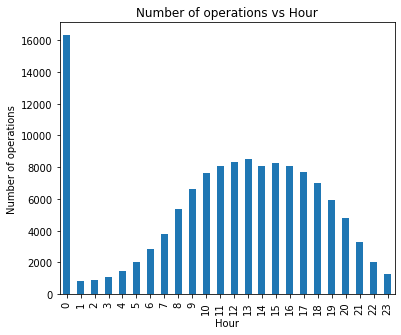

In [23]:
data.groupby(['hour'])['sum'].count().plot(kind='bar', title='Number of operations vs Hour', ylabel='Number of operations',
         xlabel='Hour', figsize=(6, 5))

We see, that at 00 there is a surprisingly high number of operations, but without this "outlier" the sales seem to be distributed normally. Yet we have seen the number of operations, but what about their amount?

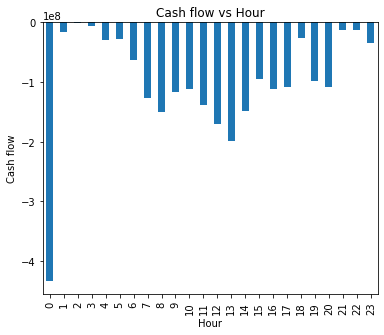

In [24]:
data.groupby(['hour'])['sum'].sum().plot(kind='bar', title='Cash flow vs Hour', ylabel='Cash flow',
         xlabel='Hour', figsize=(6, 5))

As expected from the insights in the Descriptive statistics and analysis section, most transactions are money outflow. The overall distribution of transaction sums can be viewed using a boxplot

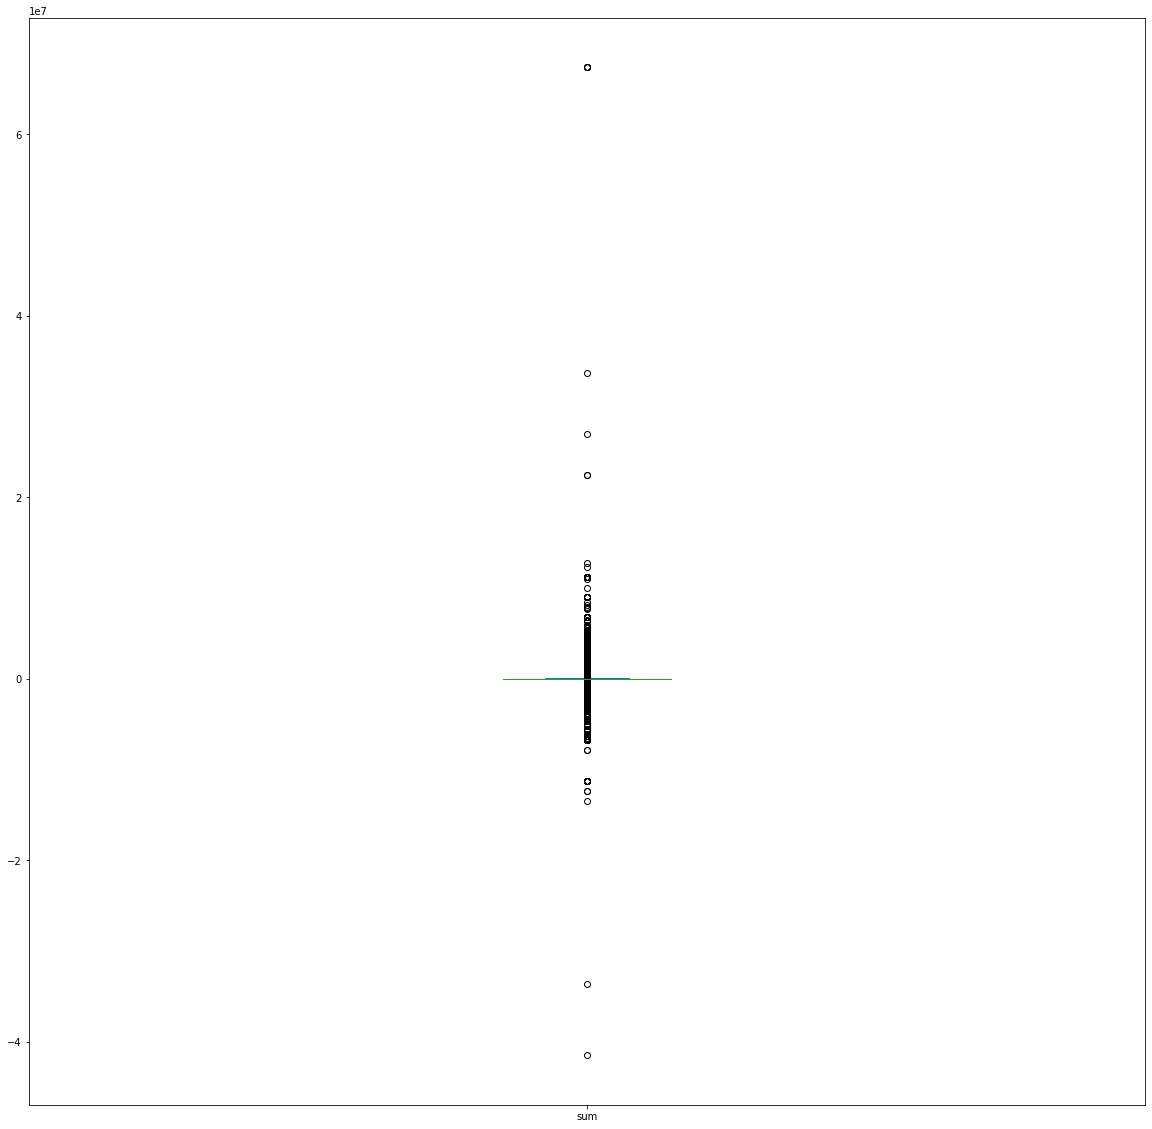

In [ ]:
data['sum'].plot.box(figsize=(20,20))

This plot shows us that there are multiple outliers. We will get rid of them

In [25]:
data = data.loc[(np.abs(data['sum'] - data['sum'].median()) < 2 * data['sum'].std())]

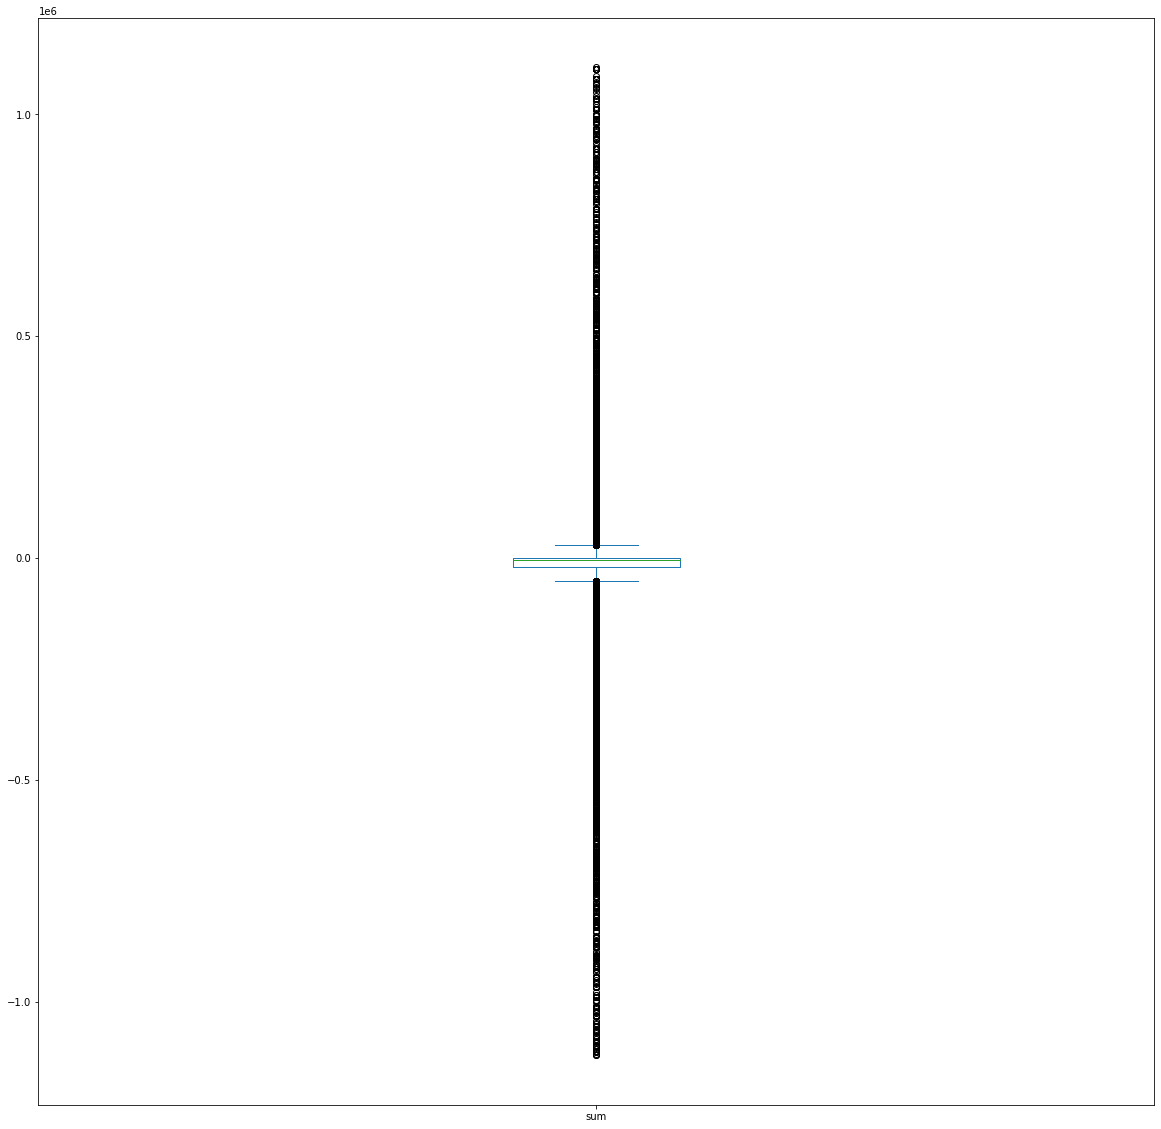

In [26]:
data['sum'].plot.box(figsize=(20,20))

Now the data looks a little bit better

Let us see the distribution of operations of different types

In [35]:
data.groupby(['type_description']).count()['client_id'].sort_values(ascending=False)

type_description
Покупка. POS                                                                                             48407
Выдача наличных в АТМ                                                                                    19820
Оплата услуги. Банкоматы                                                                                 18368
Перевод на карту (с карты) через Мобильный банк (без взимания комиссии с отправителя)                    12705
Списание с карты на карту по операции <перевода с карты на карту> через Мобильный банк (без комиссии)     6608
Взнос наличных через АТМ (в своем тер.банке)                                                              4716
Перевод на карту (с карты) через АТМ (в пределах одного тер.банка)                                        2777
Покупка.                                                                                                  2230
Покупка. Зарубеж.                                                                              

We can see disproportionality in the number of operations. Actually, the dominance of "purhcase via POS" can be easily explained: most stores have POS and people use it to purchase goods really often. 

Let us see the cash amount of top-4 (have more than 10K operations) types of operations

In [54]:
total_sum = data.loc[(data['type_description'] == "Покупка. POS ") |
         (data['type_description'] == "Выдача наличных в АТМ") |
         (data['type_description'] == "Оплата услуги. Банкоматы") |
         (data['type_description'] == "Перевод на карту (с карты) через Мобильный банк (без взимания комиссии с отправителя)")]\
         .groupby(['type_description'])['sum'].sum().apply(abs).sum()
print("Total sum of these transactions is:", total_sum)


Total sum of these transactions is: 3607011374.3300004


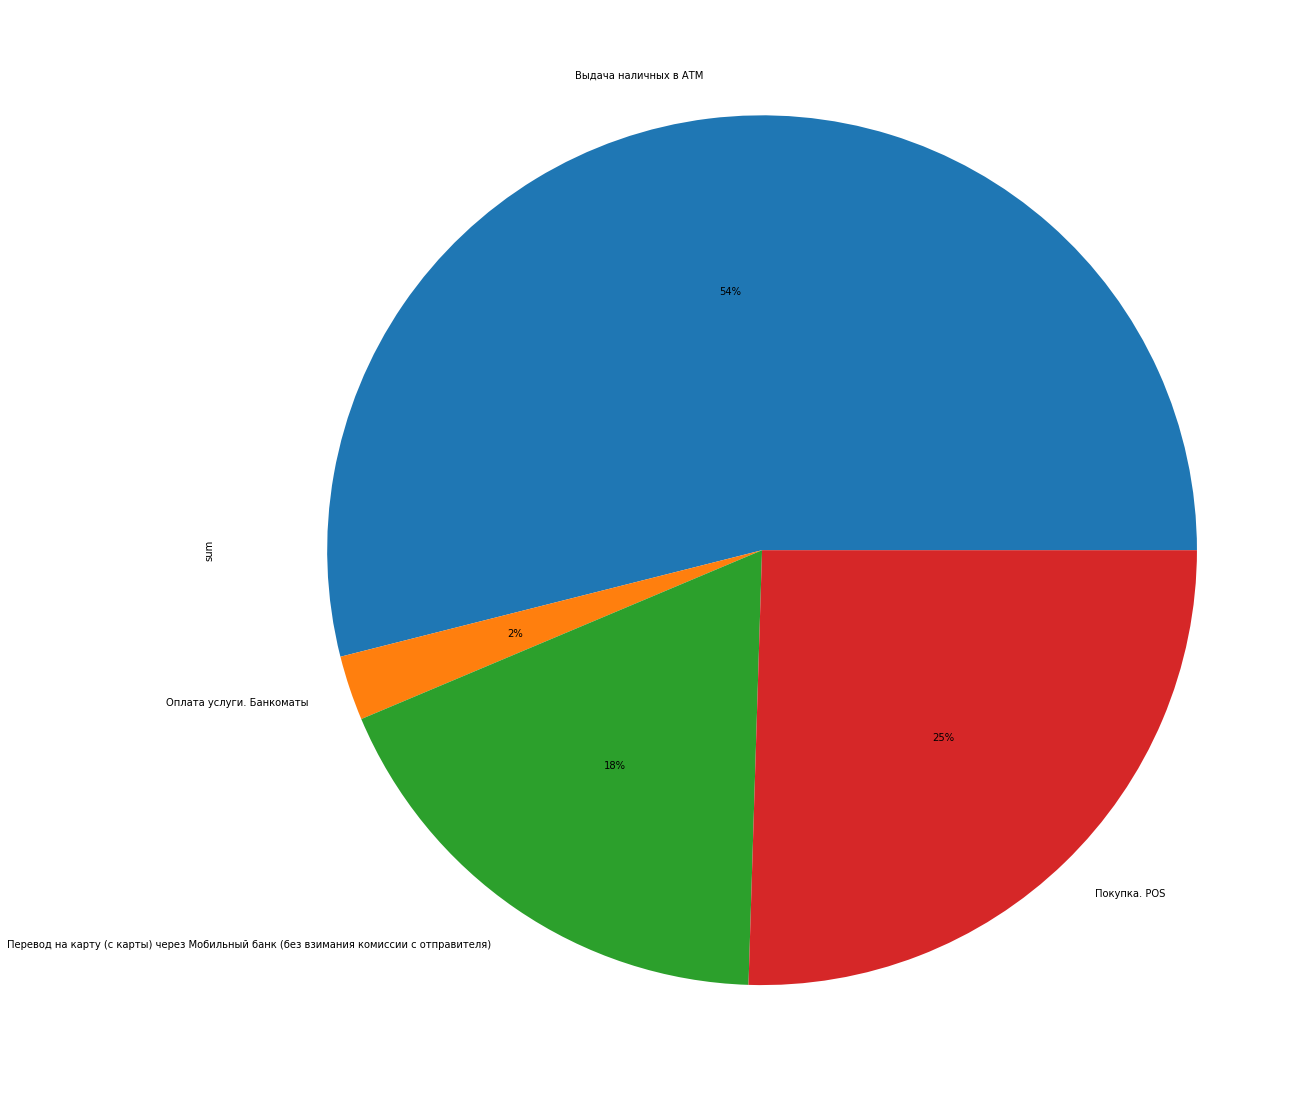

In [55]:
data.loc[(data['type_description'] == "Покупка. POS ") |
         (data['type_description'] == "Выдача наличных в АТМ") |
         (data['type_description'] == "Оплата услуги. Банкоматы") |
         (data['type_description'] == "Перевод на карту (с карты) через Мобильный банк (без взимания комиссии с отправителя)")]\
         .groupby(['type_description'])['sum'].sum().apply(abs).plot.pie(figsize=(20, 20), 
                                                                         autopct= lambda x: '{:.0f}%'.format(x))

We can see that despite the fact that there were more "purchases via POS" than all the other groups combined, the cash flow via this operation is just 25%, while "cash withdrawal via ATM" takes a half of all cash flows. It can be explained by the fact that when someone needs cash, the amount of cash is significant, while purchases can be relatively "small"

## More feature engineering

Well, now we would like to continue feature engineering. First of all, let us look at hours, minutes and seconds in the dataset. If we think about clock, we can see that 59 or 24 are closer to 2 than to 17, but since our encoding of hours, minutes and seconds use just numbers, this information is lost. So we have to make our time encodings cyclic

In [56]:
data

,client_id,datetime,code,type,sum,type_description,code_description,day,hour,minute,second
0,96372458,421 06:33:15,6011,2010,-561478.94,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,421,6,33,15
1,21717441,55 13:38:47,6011,2010,-44918.32,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,55,13,38,47
3,2444292,355 09:47:45,6011,2010,-65131.56,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,355,9,47,45
4,2132533,184 20:09:07,6011,2010,-224591.58,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,184,20,9,7
5,20166346,404 16:32:48,6011,2010,-22459.16,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,404,16,32,48
...,...,...,...,...,...,...,...,...,...,...,...
129993,51907756,136 00:00:00,4131,1200,-146433.71,Покупка. Зарубеж.,Автобусные линии,136,0,0,0
129994,61978280,401 00:00:00,5169,1200,-271194.78,Покупка. Зарубеж.,"Химикалии и смежные вещества, не классифициров...",401,0,0,0
129995,97803699,371 19:47:00,6513,1210,-60792.00,Покупка. POS Зарубеж.,Агенты и менеджеры по аренде недвижимости,371,19,47,0
129996,63953233,15 00:00:00,4411,1210,-77535.30,Покупка. POS Зарубеж.,Круизные линии,15,0,0,0


In [57]:
data['hour_sin'] = data['hour'].apply(lambda x: np.sin(x / 24 * 2 * np.pi))
data['hour_cos'] = data['hour'].apply(lambda x: np.cos(x / 24 * 2 * np.pi))

data['minute_sin'] = data['minute'].apply(lambda x: np.sin(x / 60 * 2 * np.pi))
data['minute_cos'] = data['minute'].apply(lambda x: np.cos(x / 60 * 2 * np.pi))

data['second_sin'] = data['second'].apply(lambda x: np.sin(x / 60 * 2 * np.pi))
data['second_cos'] = data['second'].apply(lambda x: np.cos(x / 60 * 2 * np.pi))



In [58]:
data

,client_id,datetime,code,type,sum,type_description,code_description,day,hour,minute,second,hour_sin,hour_cos,minute_sin,minute_cos,second_sin,second_cos
0,96372458,421 06:33:15,6011,2010,-561478.94,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,421,6,33,15,1.000000,6.123234e-17,-0.309017,-0.951057,1.000000,6.123234e-17
1,21717441,55 13:38:47,6011,2010,-44918.32,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,55,13,38,47,-0.258819,-9.659258e-01,-0.743145,-0.669131,-0.978148,2.079117e-01
3,2444292,355 09:47:45,6011,2010,-65131.56,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,355,9,47,45,0.707107,-7.071068e-01,-0.978148,0.207912,-1.000000,-1.836970e-16
4,2132533,184 20:09:07,6011,2010,-224591.58,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,184,20,9,7,-0.866025,5.000000e-01,0.809017,0.587785,0.669131,7.431448e-01
5,20166346,404 16:32:48,6011,2010,-22459.16,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,404,16,32,48,-0.866025,-5.000000e-01,-0.207912,-0.978148,-0.951057,3.090170e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129993,51907756,136 00:00:00,4131,1200,-146433.71,Покупка. Зарубеж.,Автобусные линии,136,0,0,0,0.000000,1.000000e+00,0.000000,1.000000,0.000000,1.000000e+00
129994,61978280,401 00:00:00,5169,1200,-271194.78,Покупка. Зарубеж.,"Химикалии и смежные вещества, не классифициров...",401,0,0,0,0.000000,1.000000e+00,0.000000,1.000000,0.000000,1.000000e+00
129995,97803699,371 19:47:00,6513,1210,-60792.00,Покупка. POS Зарубеж.,Агенты и менеджеры по аренде недвижимости,371,19,47,0,-0.965926,2.588190e-01,-0.978148,0.207912,0.000000,1.000000e+00
129996,63953233,15 00:00:00,4411,1210,-77535.30,Покупка. POS Зарубеж.,Круизные линии,15,0,0,0,0.000000,1.000000e+00,0.000000,1.000000,0.000000,1.000000e+00


Now the pattern in time is clearly seen

We have codes and types, they are encoded as integers, but we cannot use it just like that, because they are categorical features. We have two options: use them one-hot-encoded, or just delete.

In [59]:
dummy_codes = pd.get_dummies(data['code'])
dummy_types = pd.get_dummies(data['type'])

In [60]:
# data = data.drop('code',axis = 1)
# data = data.drop('type',axis = 1)

data = data.join(dummy_codes)
data

,client_id,datetime,code,type,sum,type_description,code_description,day,hour,minute,second,hour_sin,hour_cos,minute_sin,minute_cos,second_sin,second_cos,742,1711,1799,2741,3000,3351,3501,4111,4112,4121,4131,4214,4215,4411,4511,4722,4784,4789,4812,4814,4816,4829,4899,...,7299,7311,7338,7372,7375,7395,7399,7512,7523,7538,7542,7629,7699,7832,7841,7922,7933,7991,7993,7994,7995,7996,7997,7999,8011,8021,8043,8062,8071,8099,8220,8299,8398,8641,8699,8999,9222,9311,9399,9402
0,96372458,421 06:33:15,6011,2010,-561478.94,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,421,6,33,15,1.000000,6.123234e-17,-0.309017,-0.951057,1.000000,6.123234e-17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,21717441,55 13:38:47,6011,2010,-44918.32,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,55,13,38,47,-0.258819,-9.659258e-01,-0.743145,-0.669131,-0.978148,2.079117e-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2444292,355 09:47:45,6011,2010,-65131.56,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,355,9,47,45,0.707107,-7.071068e-01,-0.978148,0.207912,-1.000000,-1.836970e-16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2132533,184 20:09:07,6011,2010,-224591.58,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,184,20,9,7,-0.866025,5.000000e-01,0.809017,0.587785,0.669131,7.431448e-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,20166346,404 16:32:48,6011,2010,-22459.16,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,404,16,32,48,-0.866025,-5.000000e-01,-0.207912,-0.978148,-0.951057,3.090170e-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129993,51907756,136 00:00:00,4131,1200,-146433.71,Покупка. Зарубеж.,Автобусные линии,136,0,0,0,0.000000,1.000000e+00,0.000000,1.000000,0.000000,1.000000e+00,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
129994,61978280,401 00:00:00,5169,1200,-271194.78,Покупка. Зарубеж.,"Химикалии и смежные вещества, не классифициров...",401,0,0,0,0.000000,1.000000e+00,0.000000,1.000000,0.000000,1.000000e+00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
129995,97803699,371 19:47:00,6513,1210,-60792.00,Покупка. POS Зарубеж.,Агенты и менеджеры по аренде недвижимости,371,19,47,0,-0.965926,2.588190e-01,-0.978148,0.207912,0.000000,1.000000e+00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
129996,63953233,15 00:00:00,4411,1210,-77535.30,Покупка. POS Зарубеж.,Круизные линии,15,0,0,0,0.000000,1.000000e+00,0.000000,1.000000,0.000000,1.000000e+00,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [61]:
data = data.join(dummy_types, lsuffix='_type')
data

,client_id,datetime,code,type,sum,type_description,code_description,day,hour,minute,second,hour_sin,hour_cos,minute_sin,minute_cos,second_sin,second_cos,742,1711,1799,2741,3000,3351,3501,4111,4112,4121,4131,4214,4215,4411,4511,4722,4784,4789,4812,4814,4816,4829,4899,...,2440,4010,4011,4020,4021,4031,4041,4051,4061,4071,4090,4110,4200,4210,4500,6010,6100,6110,6200,6210,7010,7011,7014,7015,7020,7021,7024,7025,7030,7031,7034,7035,7040,7041,7070,7071,7074,7075,8100,8145
0,96372458,421 06:33:15,6011,2010,-561478.94,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,421,6,33,15,1.000000,6.123234e-17,-0.309017,-0.951057,1.000000,6.123234e-17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,21717441,55 13:38:47,6011,2010,-44918.32,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,55,13,38,47,-0.258819,-9.659258e-01,-0.743145,-0.669131,-0.978148,2.079117e-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2444292,355 09:47:45,6011,2010,-65131.56,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,355,9,47,45,0.707107,-7.071068e-01,-0.978148,0.207912,-1.000000,-1.836970e-16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2132533,184 20:09:07,6011,2010,-224591.58,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,184,20,9,7,-0.866025,5.000000e-01,0.809017,0.587785,0.669131,7.431448e-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,20166346,404 16:32:48,6011,2010,-22459.16,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,404,16,32,48,-0.866025,-5.000000e-01,-0.207912,-0.978148,-0.951057,3.090170e-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129993,51907756,136 00:00:00,4131,1200,-146433.71,Покупка. Зарубеж.,Автобусные линии,136,0,0,0,0.000000,1.000000e+00,0.000000,1.000000,0.000000,1.000000e+00,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
129994,61978280,401 00:00:00,5169,1200,-271194.78,Покупка. Зарубеж.,"Химикалии и смежные вещества, не классифициров...",401,0,0,0,0.000000,1.000000e+00,0.000000,1.000000,0.000000,1.000000e+00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
129995,97803699,371 19:47:00,6513,1210,-60792.00,Покупка. POS Зарубеж.,Агенты и менеджеры по аренде недвижимости,371,19,47,0,-0.965926,2.588190e-01,-0.978148,0.207912,0.000000,1.000000e+00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
129996,63953233,15 00:00:00,4411,1210,-77535.30,Покупка. POS Зарубеж.,Круизные линии,15,0,0,0,0.000000,1.000000e+00,0.000000,1.000000,0.000000,1.000000e+00,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


And the last, but not the least, we have to normalize sums, so that this feature has normal distribution

In [62]:
data['sum'] = (data['sum'] - data['sum'].mean())/data['sum'].std()

So we have engineered a lot of features!

## Unsupervised learning

We have prepared our data for clustering. We will try k-means and heirarchical clustering. Also, we will use unique client ids, so that no clusters by id appear

But first of all, let us conduct several experiments: 
* With time and sums only
* With all features, generated in the previous step


In [63]:
test_1 = data[['client_id', 'hour_sin', 'hour_cos', 'minute_sin',	'minute_cos',	'second_sin',	'second_cos', 'sum']]
test_1 = test_1.groupby(['client_id'], as_index=True)[test_1.columns[1:]].mean()
test_1

,hour_sin,hour_cos,minute_sin,minute_cos,second_sin,second_cos,sum
client_id,,,,,,,
22899,-0.196236,-0.535477,-0.685894,-0.108216,0.015923,0.086591,0.184994
27914,-0.004410,-0.699469,0.047746,-0.454270,0.073924,-0.230285,0.285098
28753,0.145766,-0.110190,0.091244,0.409421,-0.235231,0.293374,0.257540
31385,-0.099182,-0.242161,0.182849,-0.120544,0.467691,-0.062527,0.091142
38084,-0.431426,-0.128208,-0.063640,0.360517,0.056476,0.187885,0.348399
...,...,...,...,...,...,...,...
99967537,0.707107,-0.707107,-0.500000,0.866025,-0.104528,0.994522,-2.477409
99984336,-0.531211,-0.799494,-0.398199,0.068128,0.296997,0.487195,0.293827
99985917,0.258819,-0.965926,-0.951057,-0.309017,0.406737,-0.913545,-1.604579


In [64]:
from sklearn.cluster import KMeans

from matplotlib import pyplot as plt

def use_elbow(X):
  distorsions = []
  for k in range(2, 20):
      kmeans = KMeans(n_clusters=k)
      kmeans.fit(X)
      distorsions.append(kmeans.inertia_)

  fig = plt.figure(figsize=(15, 5))
  plt.plot(range(2, 20), distorsions)
  plt.grid(True)
  plt.title('Elbow curve')

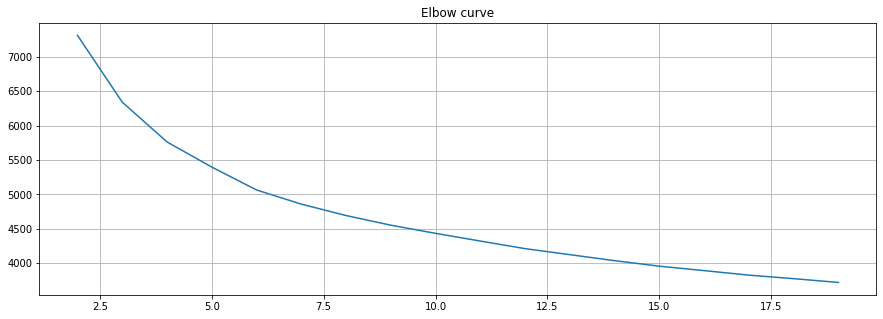

In [65]:
use_elbow(test_1)

With this data, only 3 clustar are ok

In [66]:
test_2 = data.drop(['type_description',	'code_description',	'day',	'hour',	'minute',	'second'], axis=1)
test_2 = test_2.groupby(['client_id'], as_index=True)[test_2.columns[1:]].mean()
test_2.columns = [str(x) for x in test_2.columns]

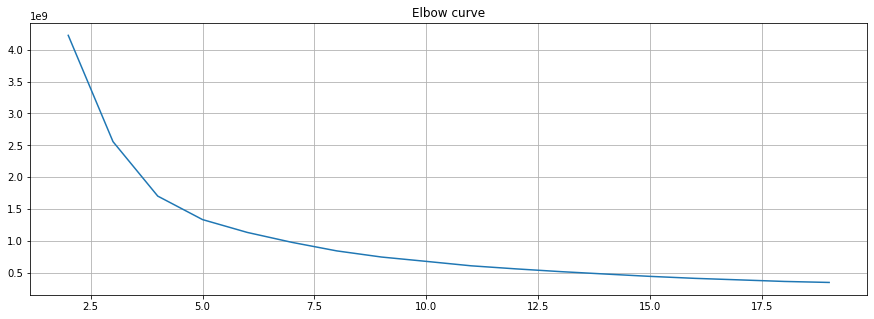

In [67]:
use_elbow(test_2)

Here are about 5 clusters

We were using 245 features, so interpreting clusters is barely possible. We can reduce dimensionality in order to get better results and see the clusters in the data. For dimensionality reduction we will use PCA

In [68]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
test_2 = pca.fit_transform(test_2)

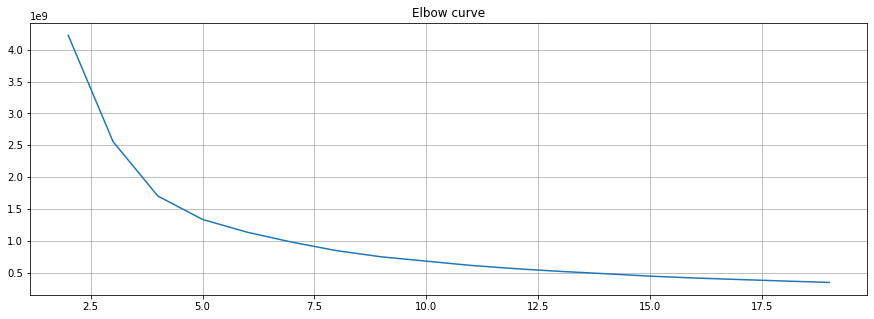

In [69]:
use_elbow(test_2)

Again we see 5 clusters

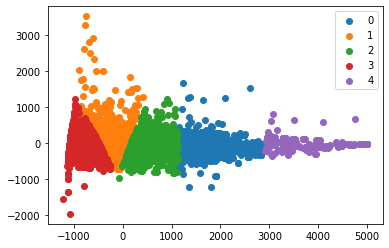

In [71]:
kmeans = KMeans(n_clusters= 5)
 
labels = kmeans.fit_predict(test_2)

u_labels = np.unique(labels)
 
 
for i in u_labels:
    plt.scatter(test_2[labels == i , 0] , test_2[labels == i , 1] , label = i)
plt.legend()
plt.show()

We can agree with some of these clusters, but it looks like if we overdid with features

In [72]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
test_1 = pca.fit_transform(test_1)

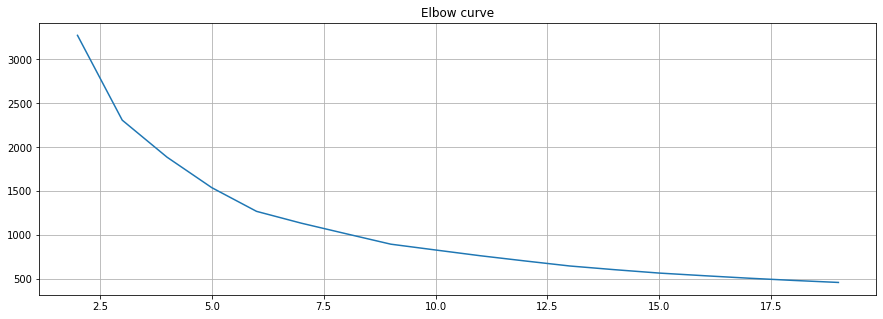

In [73]:
use_elbow(test_1)

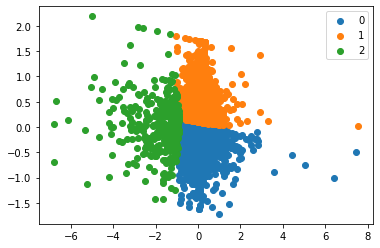

In [74]:
kmeans = KMeans(n_clusters= 3)
 
labels = kmeans.fit_predict(test_1)

u_labels = np.unique(labels)
 
 
for i in u_labels:
    plt.scatter(test_1[labels == i , 0] , test_1[labels == i , 1] , label = i)
plt.legend()
plt.show()

In [75]:
test_3 = data.drop(['type_description',	'code_description',	'day',	'hour',	'minute',	'second'], axis=1)
test_3 = test_3.groupby(['client_id'], as_index=True)[test_3.columns[1:]].mean()
test_3.columns = [str(x) for x in test_3.columns]

test_3 = pd.DataFrame(index = test_3.index, data=test_2)

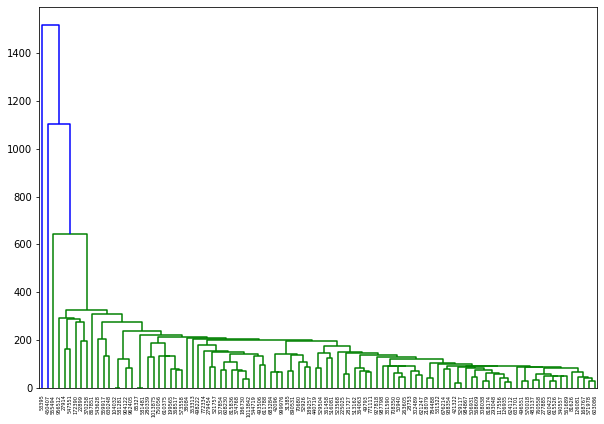

In [76]:
# let us try heirarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

linked = linkage(test_2[:100], 'single')

labelList = test_3.index.tolist()[:100]

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

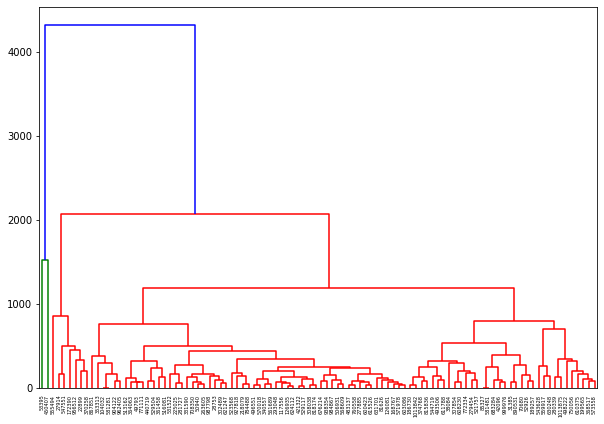

In [77]:
# let us try heirarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

linked = linkage(test_2[:100], 'average')

labelList = test_3.index.tolist()[:100]

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

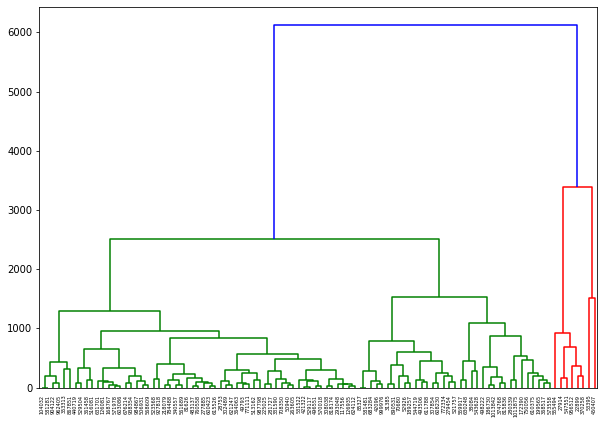

In [78]:
# let us try heirarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

linked = linkage(test_2[:100], 'complete')

labelList = test_3.index.tolist()[:100]

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

## Analysis and conclusion

Well, it seems like we failed to cluster transactions. There are several possible reasons. Most probably:
* The given data cannot be clustered without further feature engineering
* We overdid with features and using less samples and features we would achieve better results (it is seen in our experiment with first 100 clients, heirarchical clustering - both complete and average - did a great job clustering them and it could be used for cohort analysis)

Probably, it would be a better idea to use fewer features and clients and try to cluster users by their transactions.

However, we have demonstrated and ability to generate features, plot informative graphs and find insights in the data, which is a great attempt.